In [40]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

path = str(Path(Path('thermo.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import scipy
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
import tools
from tools.FV3_tools import read_solo_fields, read_solo_w
from tools.CM1_tools import read_cm1_fields, read_cm1_w

from pltbook import nice_clevels, nice_mxmnintvl, container, plot_contour_row
from tools.CM1_tools import read_cm1_fields, read_cm1_w
from tools.FV3_tools import read_solo_fields, read_solo_w

import matplotlib.colors as mcolors

cmap_data = [(1.0,                1.0,                 1.0),
             (0.3137255012989044, 0.8156862854957581,  0.8156862854957581),
             (0.0,                1.0,                 1.0),
             (0.0,                0.8784313797950745,  0.501960813999176),
             (0.0,                0.7529411911964417,  0.0),
             (0.501960813999176,  0.8784313797950745,  0.0),
             (1.0,                1.0,                 0.0),
             (1.0,                0.6274510025978088,  0.0),
             (1.0,                0.0,                 0.0),
             (1.0,                0.125490203499794,   0.501960813999176),
             (0.9411764740943909, 0.250980406999588,   1.0),
             (0.501960813999176,  0.125490203499794,   1.0),
             (0.250980406999588,  0.250980406999588,   1.0),
             (0.125490203499794,  0.125490203499794,   0.501960813999176),
             (0.125490203499794,  0.125490203499794,   0.125490203499794),
             (0.501960813999176,  0.501960813999176,   0.501960813999176),
             (0.8784313797950745, 0.8784313797950745,  0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872,  0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525,  0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]

linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),

     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))
]

_nthreads = 2

# draw filled contours

wclevs  = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 60, 70, 80]

wclevs2 = list(0.001 + 0.1*np.arange(12))

tclevs  = list(-40.0 + 2*np.arange(41))

pclevs  = list(-15.0 + np.arange(31))

dclevs  = list(-20.0 + np.arange(41))

zlevels = 25.0 + 60.*np.arange(300)

raw_cape = {"QV12": [915., 1430., 978.],
            "QV13": [1364.4, 1904., 1437.0],
            "QV14": [1872.2, 2354.1, 1953.3],
            "QV15": [2427.5, 2800.2, 2514.6], 
            "QV16": [ 3007.0, 3289.6,  3096.1] }

plotlabels = ["QV12", "QV14", "QV16"]

cape_mean = []

def geomean(cape):
    return (cape[0] * cape[1] * cape[2])**(1./3.)

for key in raw_cape:
    cape_mean.append(geomean(raw_cape[key]))

w_ideal = np.sqrt(2.0*np.array(cape_mean))

print(w_ideal)
print(cape_mean)
        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[46.59768368 55.70051812 64.02349047 71.77687254 79.10372129]
[1085.672061987397, 1551.273859658991, 2049.503665750544, 2575.9597158272036, 3128.6993610705954]


In [19]:
def plot_wmax(cmodel, smodel, res=3, subtitle='CM1 and FV3-SOLO'):
    
    fig, ax = plt.subplots(1,2, figsize=(16,8))

    linestyles = [':','--','solid'] 
    
    capes = [1085.672061987397, 2049.503665750544, 3128.6993610705954]

    wscale = [46.59768368, 64.02349047, 79.10372129]

    for n, item in enumerate(cmodel):
        # if n == 0:
        #     linestyle = 'solid'
        # else:
        #     linestyle = linestyle_tuple[n][1:][0]
            
        ax[0].plot(item.sec, item.w.max(axis=(1,2,3)), label=f"CM1-{int(capes[n])}", linestyle=linestyles[n], color='k')
        
    for n, item in enumerate(smodel):
        # if n == 0:
        #     linestyle = 'solid'
        # else:
        #     linestyle = linestyle_tuple[n][1:][0]
            
        ax[0].plot(item.sec, item.w.max(axis=(1,2,3)), label=f"FV3-{int(capes[n])}", linestyle=linestyles[n], color='r')
    
    ax[0].set_xlim(0,3600)
    ax[0].set_title(f'DX = {res} KM: W Time Series for {subtitle}')
    ax[0].legend()
    ax[0].set_xlabel('Time (sec)')
    ax[0].set_ylabel('W (m/s)')
    ax[0].axvline(x=1100., color='k', linestyle='solid', alpha=0.4)
    
    for n, item in enumerate(cmodel):
        if n == 0:
            linestyle = 'solid'
        else:
            linestyle = linestyle_tuple[n][1:][0]
            
        ax[1].plot(item.sec, item.w.max(axis=(1,2,3))/wscale[n], label=f"CM1-{int(capes[n])}", linestyle=linestyles[n], color='k')
        
    for n, item in enumerate(smodel):
        if n == 0:
            linestyle = 'solid'
        else:
            linestyle = linestyle_tuple[n][1:][0]
            
        ax[1].plot(item.sec, item.w.max(axis=(1,2,3))/wscale[n], label=f"FV3-{int(capes[n])}", linestyle=linestyles[n], color='r')
    
    ax[1].set_xlim(0,3600)
    ax[1].set_ylim(0,1.2)
    ax[1].axhline(y=0.9995, color='k', linestyle='solid', alpha=0.4)
    ax[1].axvline(x=1100., color='k', linestyle='solid', alpha=0.4)
    ax[1].set_title(f'DX = {res} KM: Scaled W Time Series for {subtitle}')
    ax[1].set_xlabel('Time (sec)')
    ax[1].legend()
    ax[1].set_ylabel('Fraction of Max W from Cape');

In [20]:
euler_3km  = '/work/wicker/climate_runs/FV3_Solo/bubble/euler/3km'
cm1_3km    = '/work/wicker/climate_runs/cm1r20.3/run/bubble/3km'

# s3 = []
# c3 = []

# for key in plotlabels:  
#     s3.append(read_solo_w(os.path.join(euler_3km,key)))
#     c3.append(read_cm1_w(os.path.join(cm1_3km,key)))


# rk3_3km  = '/work/wicker/climate_runs/FV3_Solo/bubble/rk2c/3km'
# rk3_1km  = '/work/wicker/climate_runs/FV3_Solo/bubble/rk3/1km'

# ** 3km plots**

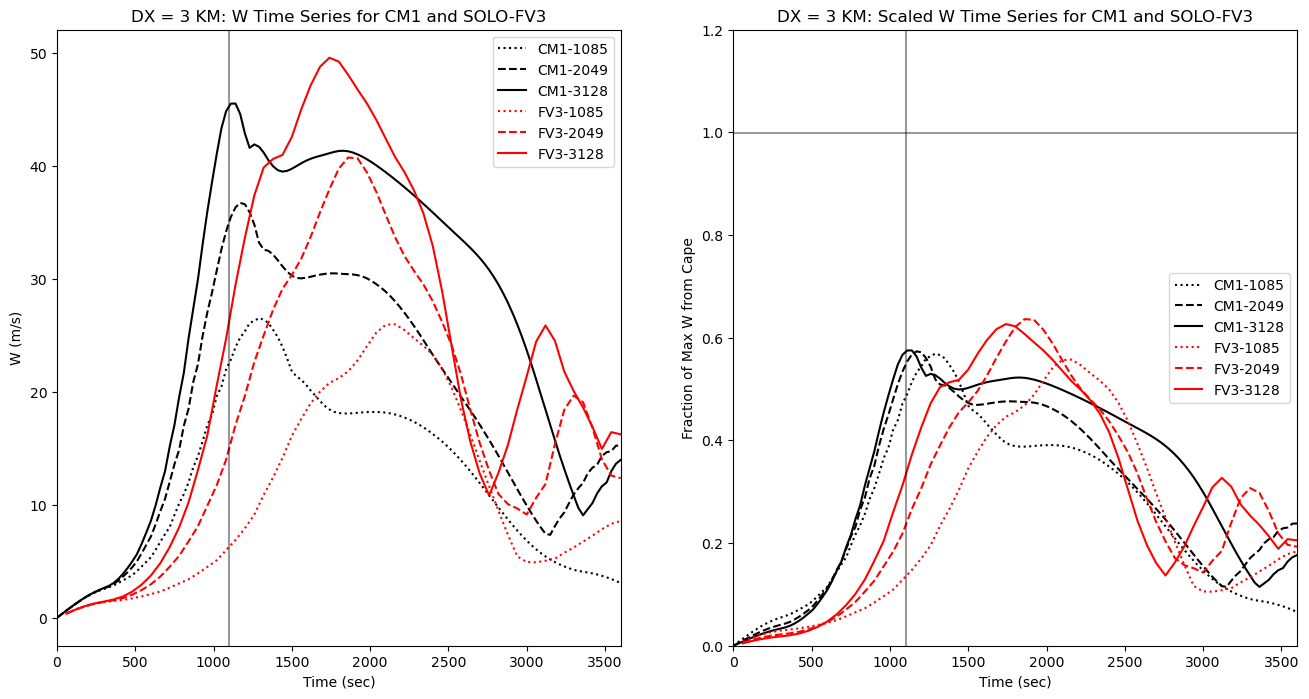

In [21]:

plot_wmax(c3, s3, res=3, subtitle='CM1 and SOLO-FV3')

# rk2 = []

# for key in plotlabels:  
#     rk2.append(read_solo_w(os.path.join(rk2_3km,key)))


# plot_wmax(c3, rk2, res=3, subtitle='CM1 and SOLO-NEW SOLVER')

# **1 km plots**

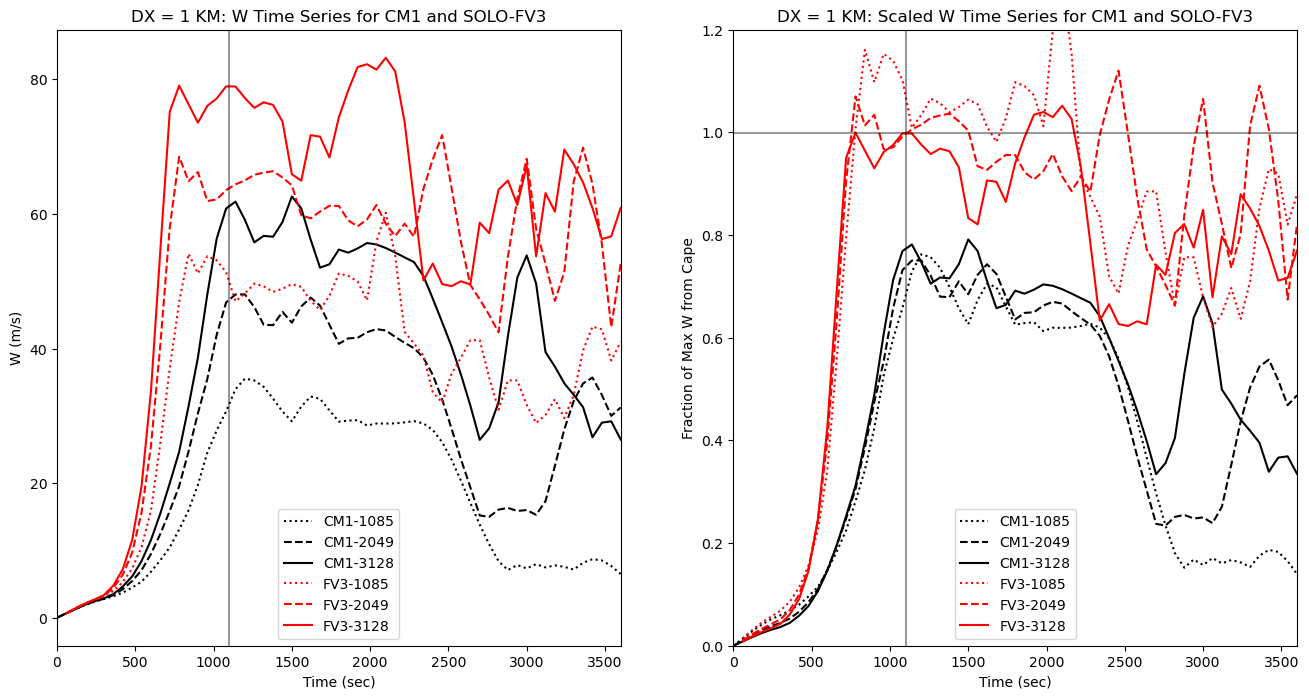

In [22]:
euler_1km  = '/work/wicker/climate_runs/FV3_Solo/bubble/euler/1km'
cm1_1km    = '/work/wicker/climate_runs/cm1r20.3/run/bubble/1km'

# s1 = []
# c1 = []

# for key in plotlabels:  
#     s1.append(read_solo_w(os.path.join(euler_1km,key)))
#     c1.append(read_cm1_w(os.path.join(cm1_1km,key)))
    
plot_wmax(c1, s1, res=1, subtitle='CM1 and SOLO-FV3')


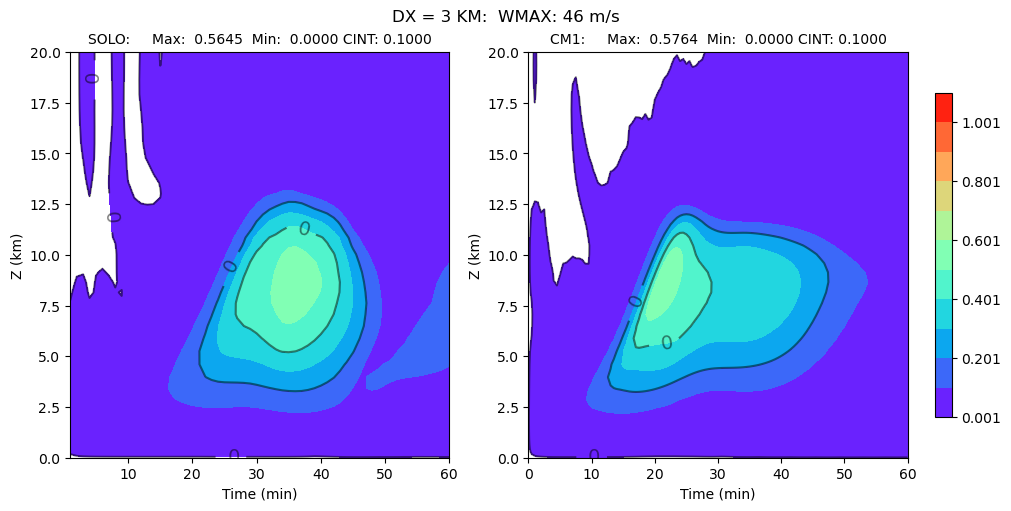

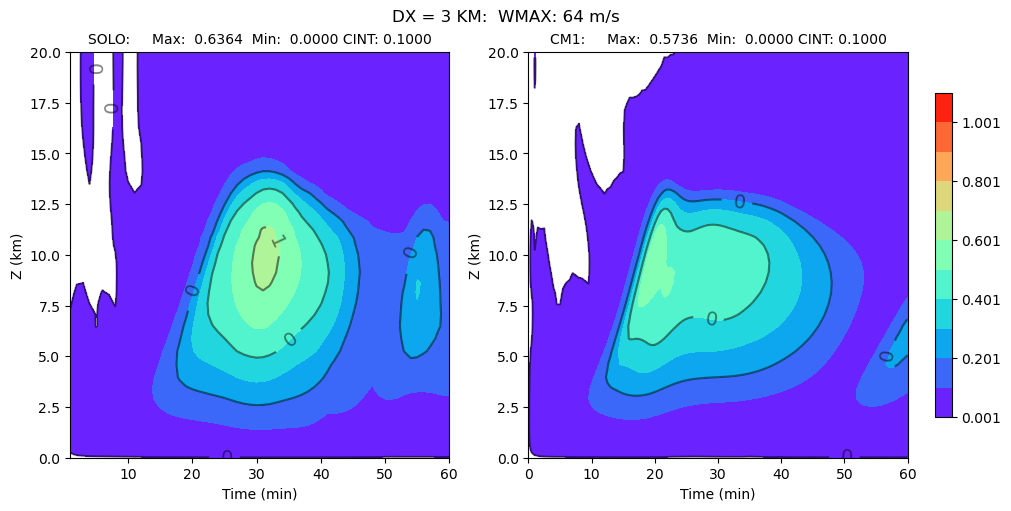

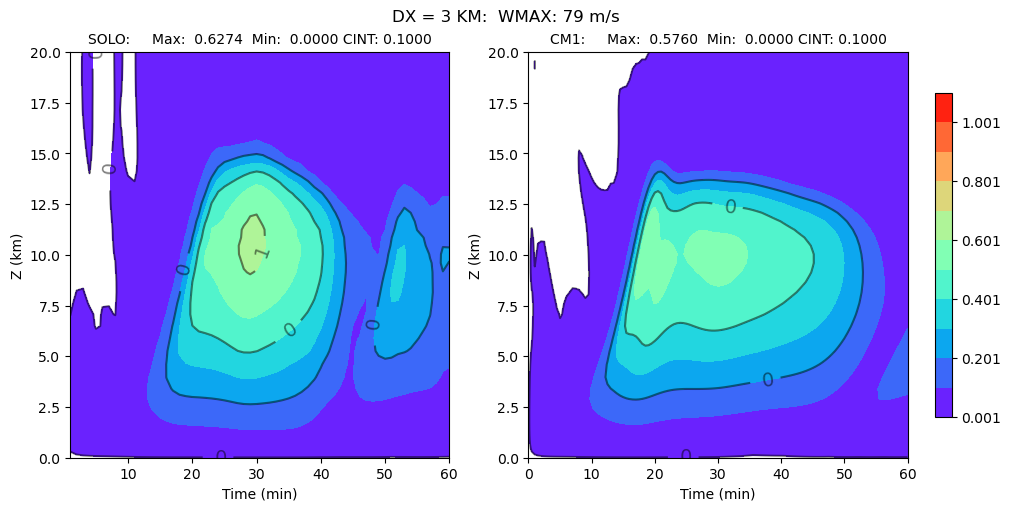

In [43]:
## 3 km plots

# for n, value in enumerate((1085, 2049, 3128)):

#     fields = []
#     fields.append(container(s3[n].w.max(axis=(2,3)).transpose(), s3[n].zc[0,:,0,0]/1000., s3[n].min))
#     fields.append(container(c3[n].w.max(axis=(2,3)).transpose(), s3[n].zc[0,:,0,0]/1000., c3[n].min))

#     plot_contour_row(fields, levels=wclevs, suptitle=f"DX = 3 KM:  CAPE: {value} J/kg", ptitle=['SOLO','CM1'], xlabel='Time (min)', ylabel='Z (km)', extra_levels=wclevs, 
#                  cmap=plt.cm.viridis_r, cint=2.5, ylim=(0,20.));

for n, value in enumerate((46,64,79)):

    fields = []
    fields.append(container(s3[n].w.max(axis=(2,3)).transpose()/value, s3[n].zc[0,:,0,0]/1000., s3[n].min))
    fields.append(container(c3[n].w.max(axis=(2,3)).transpose()/value, s3[n].zc[0,:,0,0]/1000., c3[n].min))

    plot_contour_row(fields, levels=wclevs2, suptitle=f"DX = 3 KM:  WMAX: {value} m/s", ptitle=['SOLO','CM1'], xlabel='Time (min)', 
                     ylabel='Z (km)', cint=0.1, cmap=plt.cm.rainbow, ylim=(0,20.));


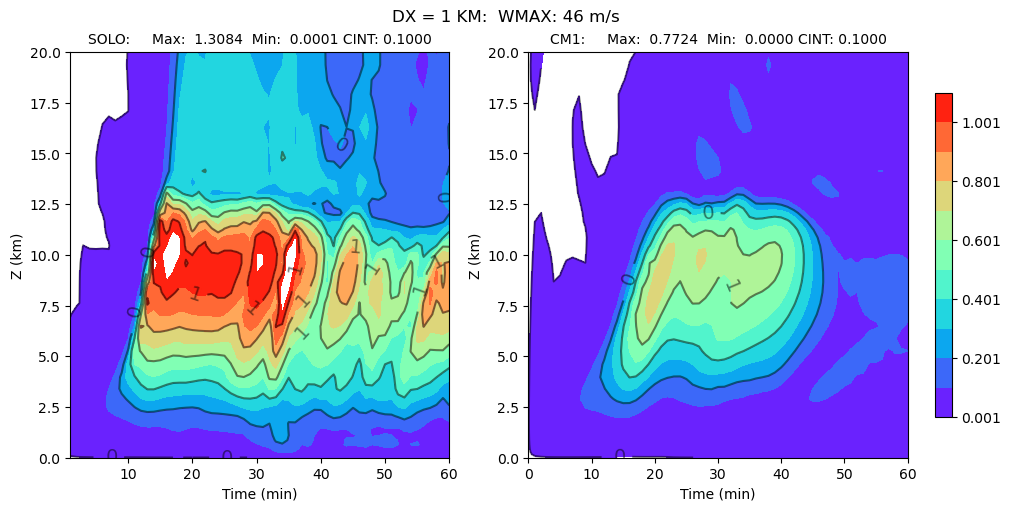

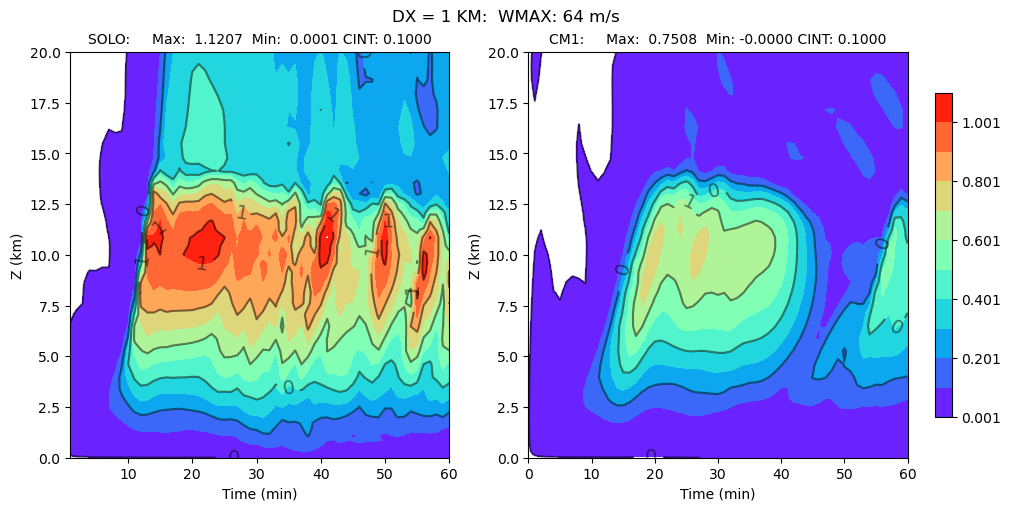

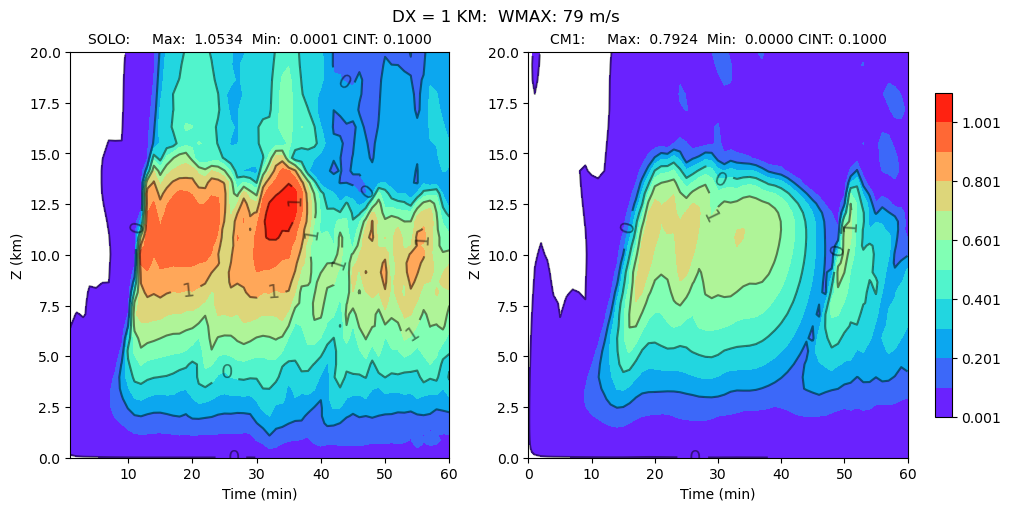

In [44]:
for n, value in enumerate((46,64,79)):

    fields = []
    # fields.append(container(s1[n].w.max(axis=(2,3)).transpose(), s1[n].zc[0,:,0,0]/1000., s1[n].min))
    # fields.append(container(c1[n].w.max(axis=(2,3)).transpose(), s1[n].zc[0,:,0,0]/1000., c1[n].min))

    fields.append(container(s1[n].w.max(axis=(2,3)).transpose()/value, s1[n].zc[0,:,0,0]/1000., s1[n].min))
    fields.append(container(c1[n].w.max(axis=(2,3)).transpose()/value, s1[n].zc[0,:,0,0]/1000., c1[n].min))


    plot_contour_row(fields, levels=wclevs2, suptitle=f"DX = 1 KM:  WMAX: {value} m/s", ptitle=['SOLO','CM1'], xlabel='Time (min)', ylabel='Z (km)', extra_levels=wclevs, 
                 cmap=plt.cm.rainbow, cint=0.1, ylim=(0,20.));


(63, 64) 2.9472046


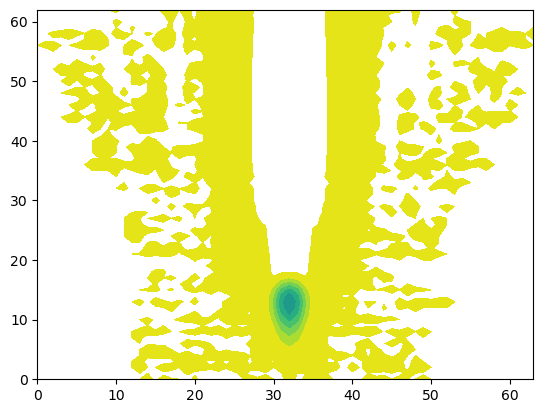

In [101]:
cmin = 0.0
cmax = 5.0
cinc = 1.0
cntlevels = 0.5*np.arange(13)

t0 = s3.theta[0,:,0,0]

s_t = s3.theta[0,:,jloc,:]

ppt = np.zeros_like(s_t)

for k in np.arange(s_t.shape[0]):
    ppt[k,:] = s_t[k,:] - t0[k]

print(ppt.shape,ppt.max())

ppt = ppt[::-1,]

plt.contourf(ppt[:,:], levels=cntlevels, cmap=plt.cm.viridis_r)

In [53]:
sres = []
cres = []

loc_solo  = '/work/wicker/climate_runs/FV3_Solo/bubble/'
loc_cm1   = '/work/wicker/climate_runs/cm1r20.3/run/bubble/'

from tools.CM1_tools import read_cm1_fields, read_cm1_w
from tools.FV3_tools import read_solo_fields, read_solo_w

for res in ['1km', '2km', '4km', '8km', '12km']:  
    sres.append(read_solo_w(os.path.join(loc_solo, res, 'QV16')))
    cres.append(read_cm1_w(os.path.join(loc_cm1, res, 'QV16')))

------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/climate_runs/FV3_Solo/bubble/1km/QV16/atmos_hifreq.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/climate_runs/FV3_Solo/bubble/1km/QV16/atmos_hifreq.nc 

------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/climate_runs/cm1r20.3/run/bubble/1km/QV16/cm1out.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/climate_runs/cm1r20.3/run/bubble/1km/QV16/cm1out.nc 

------------------------------------------------------------------------------------------------------------------------ 

 Added default 

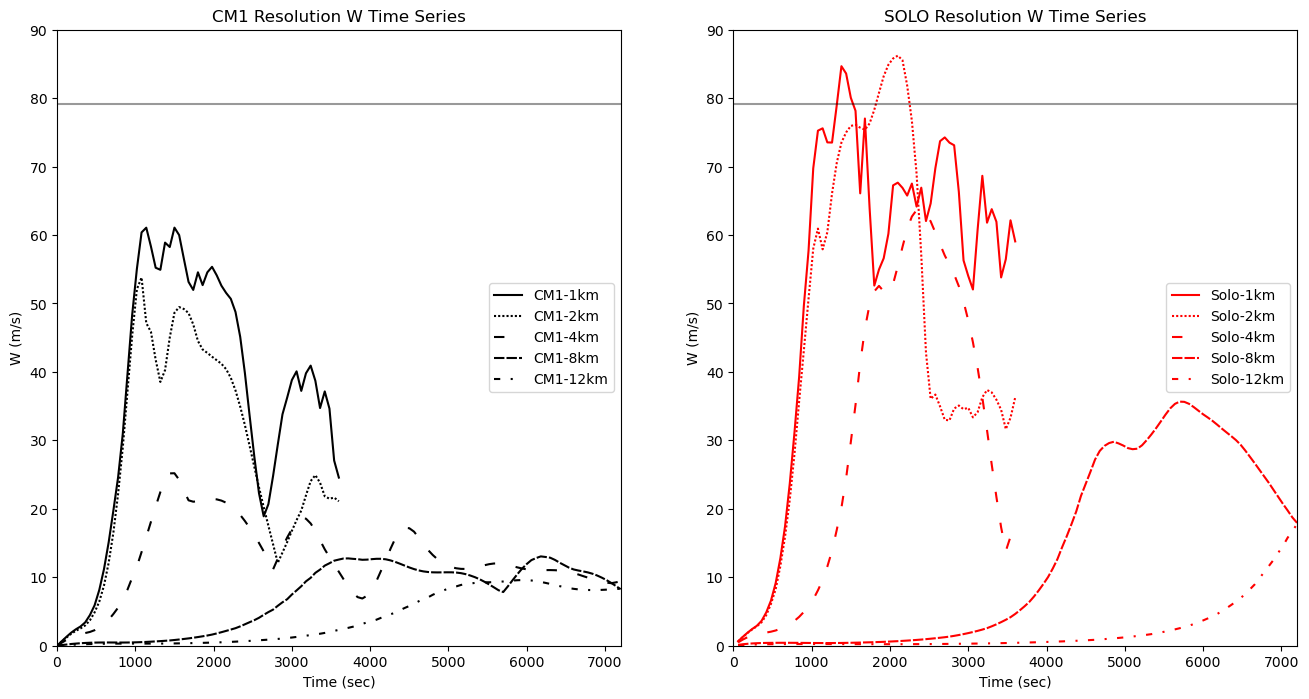

In [66]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

res_list = ['1km', '2km', '4km', '8km', '12km']

for n, item in enumerate(cres):
    if n == 0:
        linestyle = 'solid'
    else:
        linestyle = linestyle_tuple[2*n-1][1:][0]
        
    ax[0].plot(item.sec, item.w.max(axis=(1,2,3)), label=f"CM1-{res_list[n]}", linestyle=linestyle, color='k')

ax[0].set_xlim(0,7200)
ax[0].set_ylim(0,90)
ax[0].set_title('CM1 Resolution W Time Series')
ax[0].legend()
ax[0].set_xlabel('Time (sec)')
ax[0].set_ylabel('W (m/s)')
ax[0].axhline(y=w_ideal[-1], color='k', linestyle='solid', alpha=0.4)

for n, item in enumerate(sres):
    if n == 0:
        linestyle = 'solid'
    else:
        linestyle = linestyle_tuple[2*n-1][1:][0]
        
    ax[1].plot(item.sec, item.w.max(axis=(1,2,3)), label=f"Solo-{res_list[n]}", linestyle=linestyle, color='r')

ax[1].set_xlim(0,7200)
ax[1].set_ylim(0,90)
ax[1].set_title('SOLO Resolution W Time Series')
ax[1].legend()
ax[1].set_xlabel('Time (sec)')
ax[1].set_ylabel('W (m/s)')
ax[1].axhline(y=w_ideal[-1], color='k', linestyle='solid', alpha=0.4)

# for n, item in enumerate(c1):
#     if n == 0:
#         linestyle = 'solid'
#     else:
#         linestyle = linestyle_tuple[n][1:][0]
        
#     ax[1].plot(item.sec, item.w.max(axis=(1,2,3))/w_ideal[n], label=f"CM1-{int(cape_mean[n])}", linestyle=linestyle, color='k')
    
# for n, item in enumerate(s1):
#     if n == 0:
#         linestyle = 'solid'
#     else:
#         linestyle = linestyle_tuple[n][1:][0]
        
#     ax[1].plot(item.sec, item.w.max(axis=(1,2,3))/w_ideal[n], label=f"FV3-{int(cape_mean[n])}", linestyle=linestyle, color='r')

# ax[1].set_xlim(0,3600)
# ax[1].set_ylim(0,1.2)
# ax[1].axhline(y=0.9995, color='k', linestyle='solid', alpha=0.4)
# ax[1].set_title('DX = 1 KM: Scaled W Time Series for CM1 and FV3')
# ax[1].set_xlabel('Time (sec)')
# ax[1].legend()
# ax[1].set_ylabel('Fraction of Max W from Cape');

AttributeError: 'list' object has no attribute 'min'

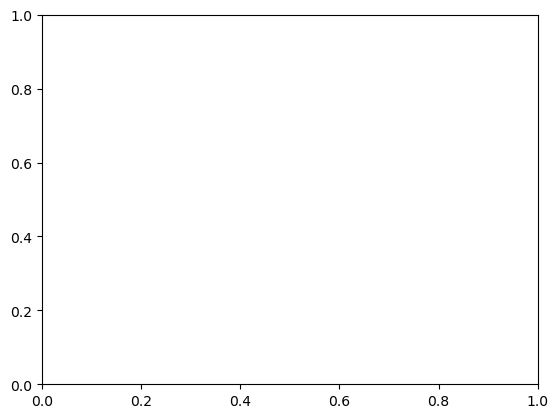

In [23]:
# Full plot

fig, ax = plt.subplots()

ax.plot(c3.min, c3.w.max(axis=(1,2,3)), color='k', linestyle='-',  label='CM1_3KM')
#plt.plot(c2.min, c2.w.max(axis=(1,2,3)), color='k', linestyle='.', label='CM1_2KM')
ax.plot(c1.min, c1.w.max(axis=(1,2,3)), color='k', linestyle='--', label='CM1_1KM')

ax.plot(s3.min, s3.w.max(axis=(1,2,3)), color='r', linestyle='-',  label='SOLO_3KM')
# plt.plot(s2.min, s2.w.max(axis=(1,2,3)), color='r', linestyle='.', label='SOLO_2KM')
ax.plot(s1.min, s1.w.max(axis=(1,2,3)), color='r', linestyle='--', label='SOLO_1KM')
ax.set_xlim(0,60)
ax.set_ylim(0,80)
ax.legend(fontsize=8)
ax.annotate('Maximum W from CAPE',
            xytext=(13,68),
            xy=(6,60),
            xycoords='data',
            arrowprops=dict(facecolor='grey', shrink=0.02),
            horizontalalignment='center', verticalalignment='center')
ax.barh(58, 60, 10, color='k', alpha=0.1);